In [1]:
import h5py
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt

import rom_operator_inference as roi

In [2]:
plt.rc("figure", dpi=300)
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

# ROM Operator Inference Example: Data-Driven Heat Equation

This example demonstrates the **data-driven** nature of the Operator Inference procedure.
A simulation for a one-dimensional heat equation was conducted previously, with snapshot data saved in the file `heat_1D_data.h5`.
The snapshots were collected at uniform time intervals of $\delta t=.01$ for $627$ time steps, so the time domain is approximately $[0,2\pi]$.
The first half of the time interval, roughly $[0,\pi]$, is designated as the training period; snapshots collected during this period will be used to train the `ROM` object.

## Preprocessing

We begin by loading the data and computing an appropriate POD basis using only the training data.
Note that the data has been shifted by a few reference vectors, such as `particular_train_left`.

In [3]:
DATAFILE = "data_driven_heat.h5"

# Load some heat data (1D snapshots)
with h5py.File(DATAFILE, 'r') as hf:
    original_data = hf["snapshots"][:,:]
    train_snapshots = hf["train_snapshots"][:,:]
    part_test_l = hf["particular_test_left"][:,:]
    part_test_r = hf["particular_test_right"][:,:]
    part_train_l = hf["particular_train_left"][:,:]
    part_train_r = hf["particular_train_right"][:,:]
    space = hf["space"][:]
    time = hf["time"][:]

# Check that the train/test data matches the full data set.
k_total = original_data.shape[1]    # Total number of snapshots.
k_train = train_snapshots.shape[1]  # Number of training snapshots.

if original_data.shape[0] == train_snapshots.shape[0]:
    print("Data aligned in the first dimension (dimension of state).")
else:
    print("Data NOT aligned in the first dimension (dimension of state).")

dt = time[1] - time[0]              # Time step.
X = train_snapshots                 # Alias the training data.

Data aligned in the first dimension (dimension of state).


To determine an appropriate dimension $r$ for the reduced model, we compute the singular values of the snapshot matrix $X$ and check to see how many are larger than $10^{-4}$, $10^{-10}$, and $10^{-14}$.

[14, 34, 42]

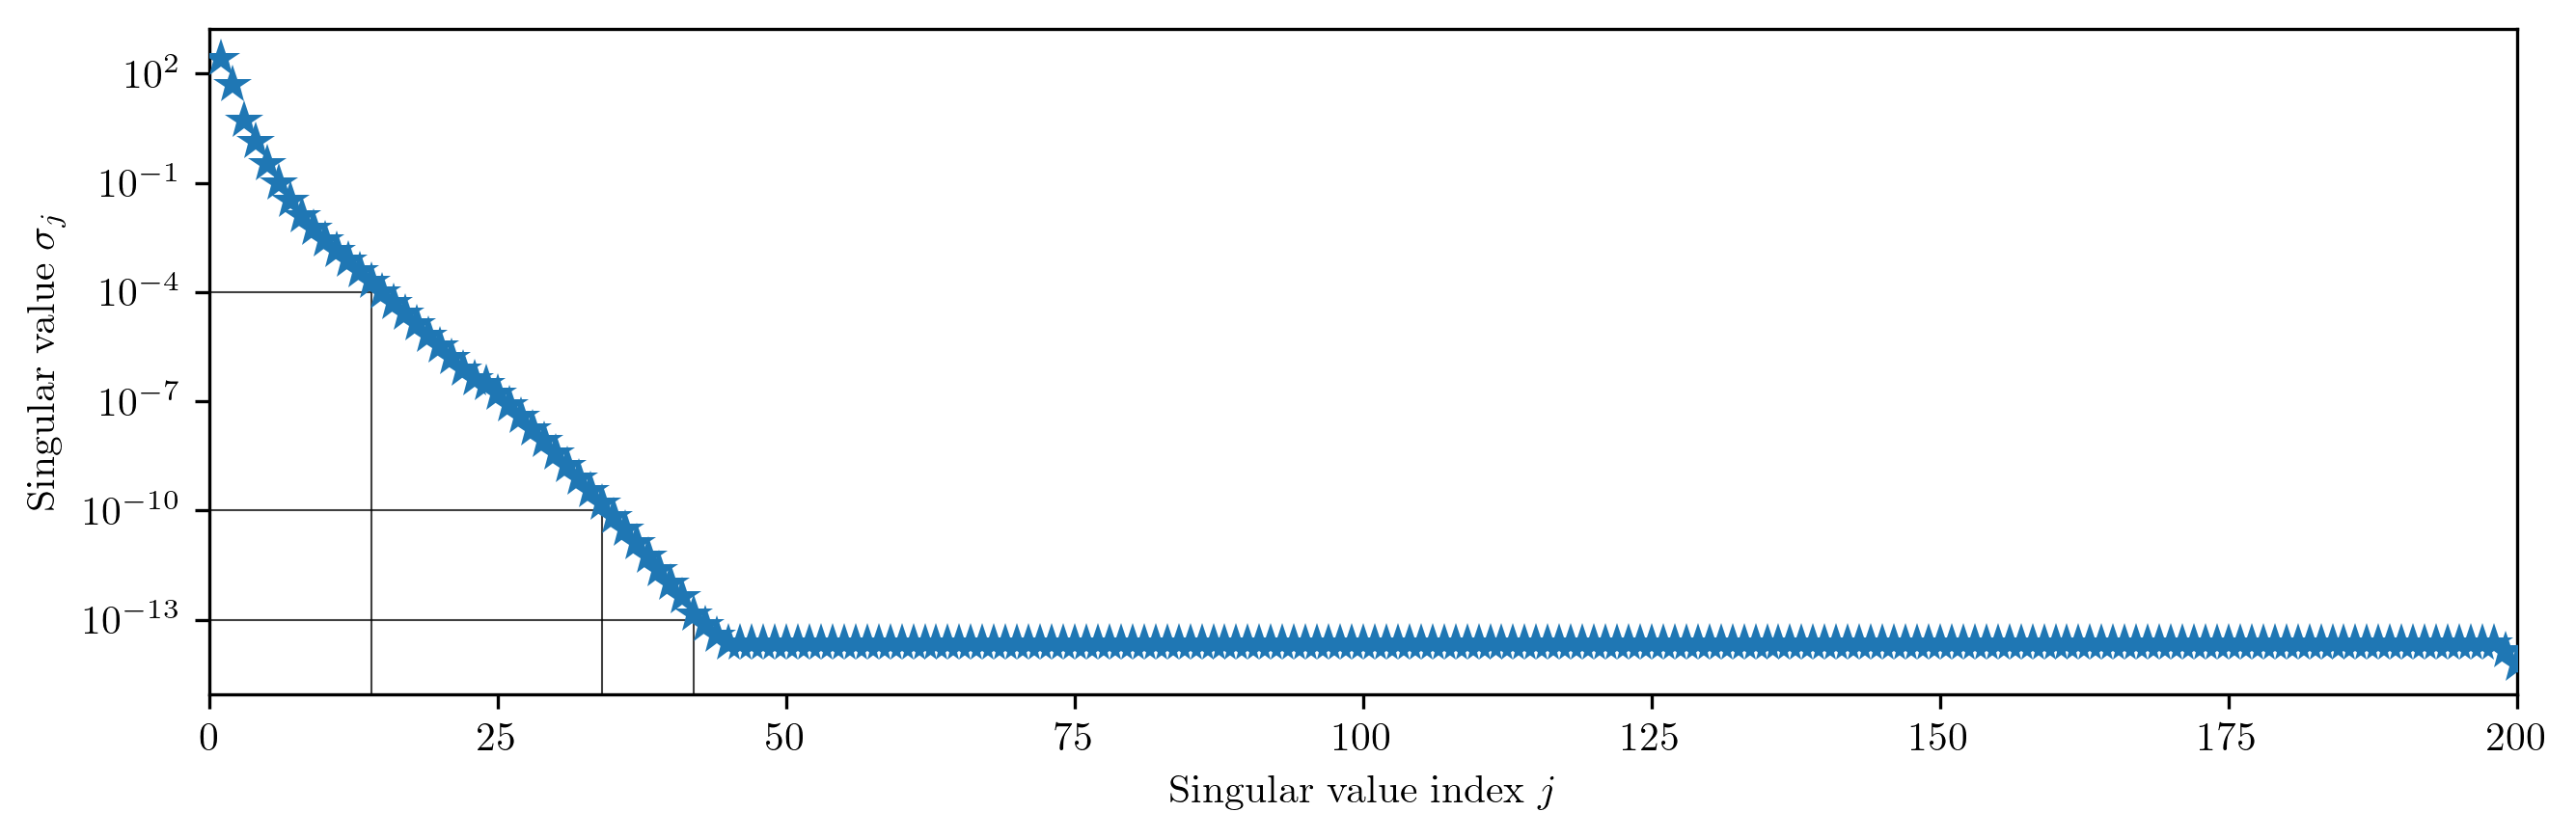

In [4]:
V, svdvals = roi.pre.pod_basis(X)
roi.pre.svdval_decay(svdvals, [1e-4, 1e-10, 1e-13], plot=True)

The singular values exhibit satisfactory exponential decay, leveling off at about $j=45$.
This suggests that $r = 45$ should be enough to capture most of the behavior of the system.

Another indicator for the reduced dimension is the amount of energy captured by the first $j$ singular values, defined by

$$
\kappa_j = \frac{\sum_{i=1}^j \sigma_i^2}{\sum_{i=1}^n \sigma_i^2}.
$$

The following function computes the smallest indices $j$ such that $\kappa_j > 99\%$, $\kappa_j > 99.9999\%$, and $\kappa_j > 99.99999999\%$.

[2, 5, 10]

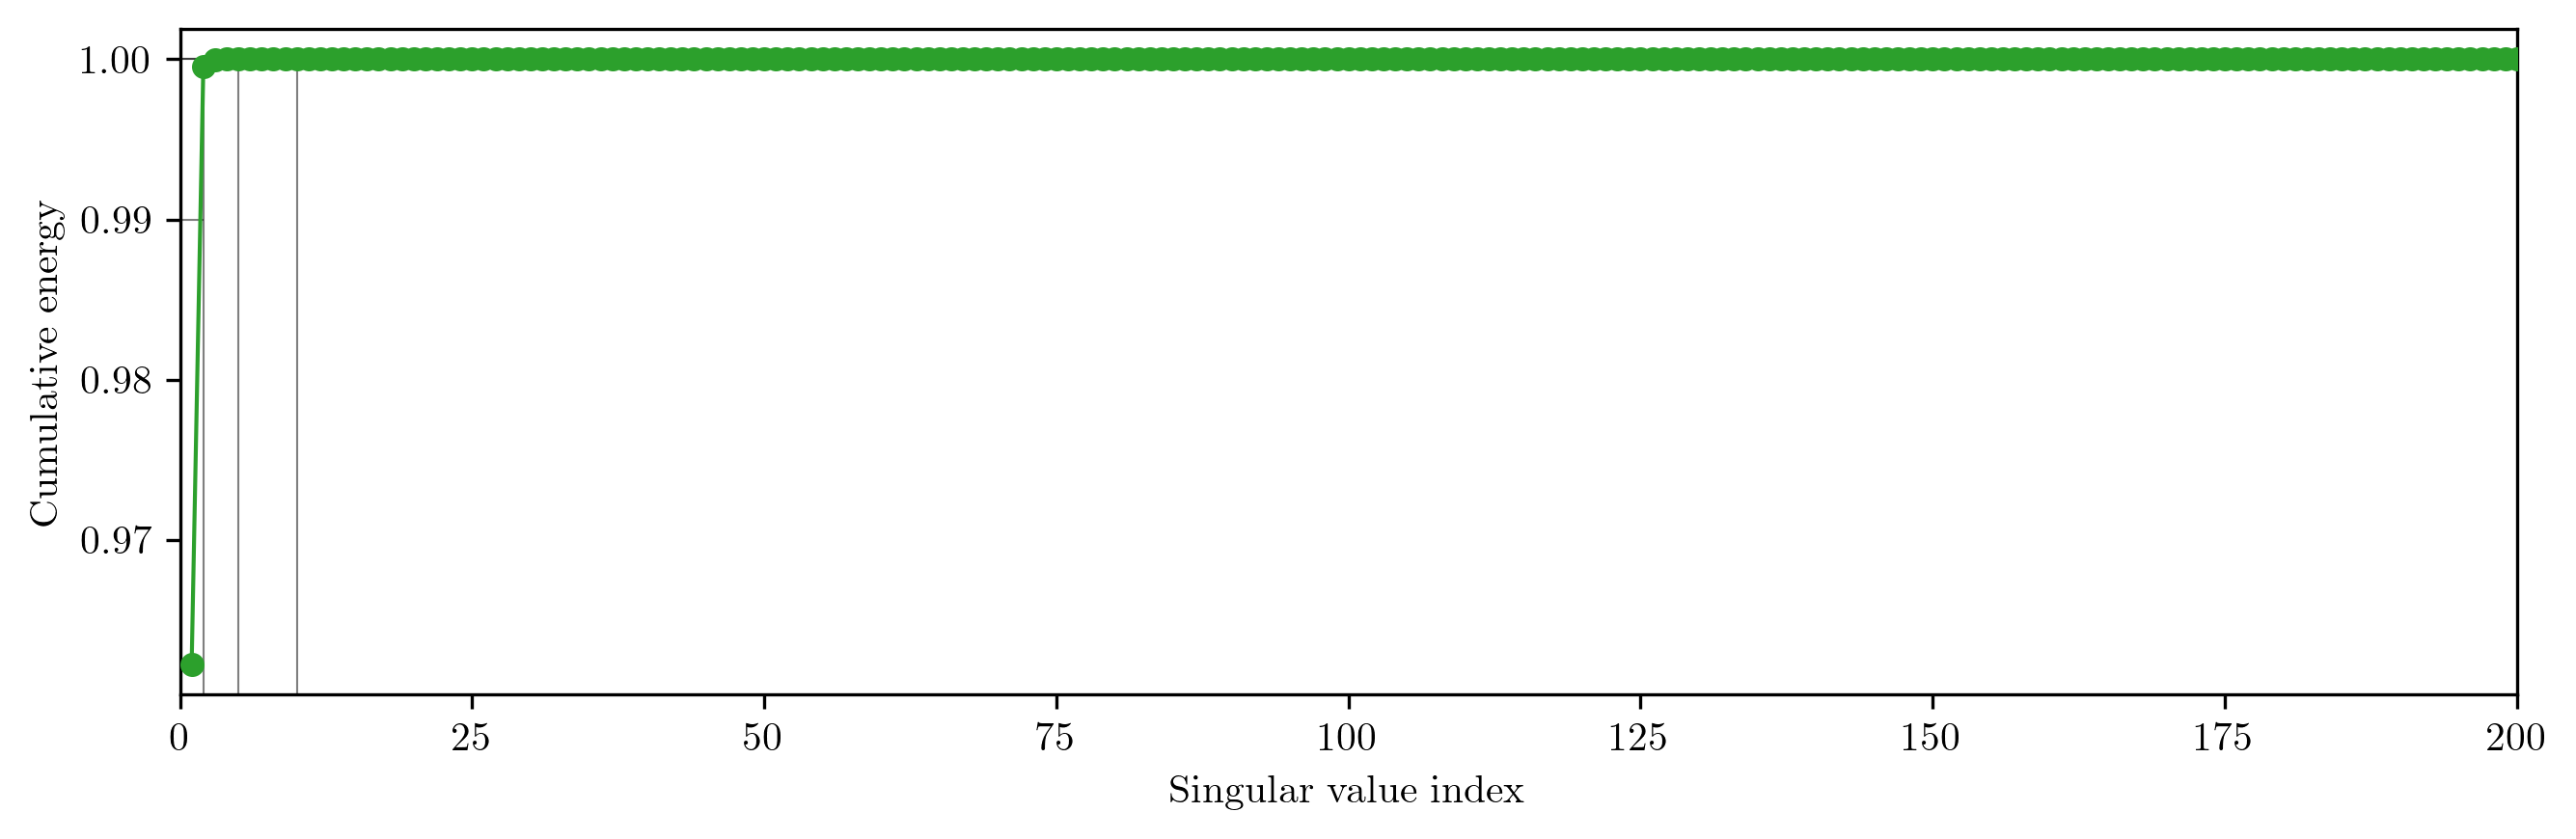

In [5]:
roi.pre.cumulative_energy(svdvals, [.99, .999999, .9999999999], plot=True)

It doesn't take many singular values to capture almost all of the energy in the system, but since the singular values don't stop decaying rapidly until $j=45$, we compromise by choosing $r=15$.
Now we can extract the POD basis of rank $r$ corresponding to $X$.

In [6]:
# Compute the POD basis.
Vr = V[:,:15]

Operator Inference also requires $\dot{X}$, the time derivative of the data.
Since this was not included in the data, we approximate it with finite differences.

In [7]:
# Approximate the time derivative of the training data.
Xdot = roi.pre.xdot_uniform(X, dt, order=2)

## Operator Inference

Since the data came from a nonhomegeneous linear model, we seek a reduced-order model of the form

$$
\dot{\hat{\mathbf{x}}}(t) = \hat{\mathbf{c}} + \hat{A}\hat{\mathbf{x}}(t).
$$

We fit a ROM of this form (`modelform="cA"`) to the data, simulate the resulting ROM over the entire time domain $[0,2\pi]$, and apply the reference shifts from the data file.

In [8]:
# Instantiate a linear model with no control inputs.
model = roi.InferredContinuousROM("cA")

# Fit the model (no input variable or regularization).
model.fit(Vr, X, Xdot)

# Simulate the model for train and test periods.
x_ROM = model.predict(X[:,0], time, method="BDF")

# Add the reference solutions back in to match original data.
x_ROM[:,k_train:] = x_ROM[:,k_train:] + part_test_l  + part_test_r
x_ROM[:,:k_train] = x_ROM[:,:k_train] + part_train_l + part_train_r

## Results

First, we visualize the predicted and actual data together.
Since the original system is one-dimensional, we can do this by plotting space against time.

In [9]:
XX,YY = np.meshgrid(space, time, indexing="ij")

xticks = [0, 2, 4]
xticklabels = [r"$0$", r"$\frac{L}{2}$", r"$L$"]
yticks = [i*np.pi/3 for i in range(7)]
yticklabels = [r"0", r"$\frac{\pi}{3}$", r"$\frac{2\pi}{3}$", r"$\pi$",
                r"$\frac{4\pi}{3}$", r"$\frac{5\pi}{3}$", r"$2\pi$"]

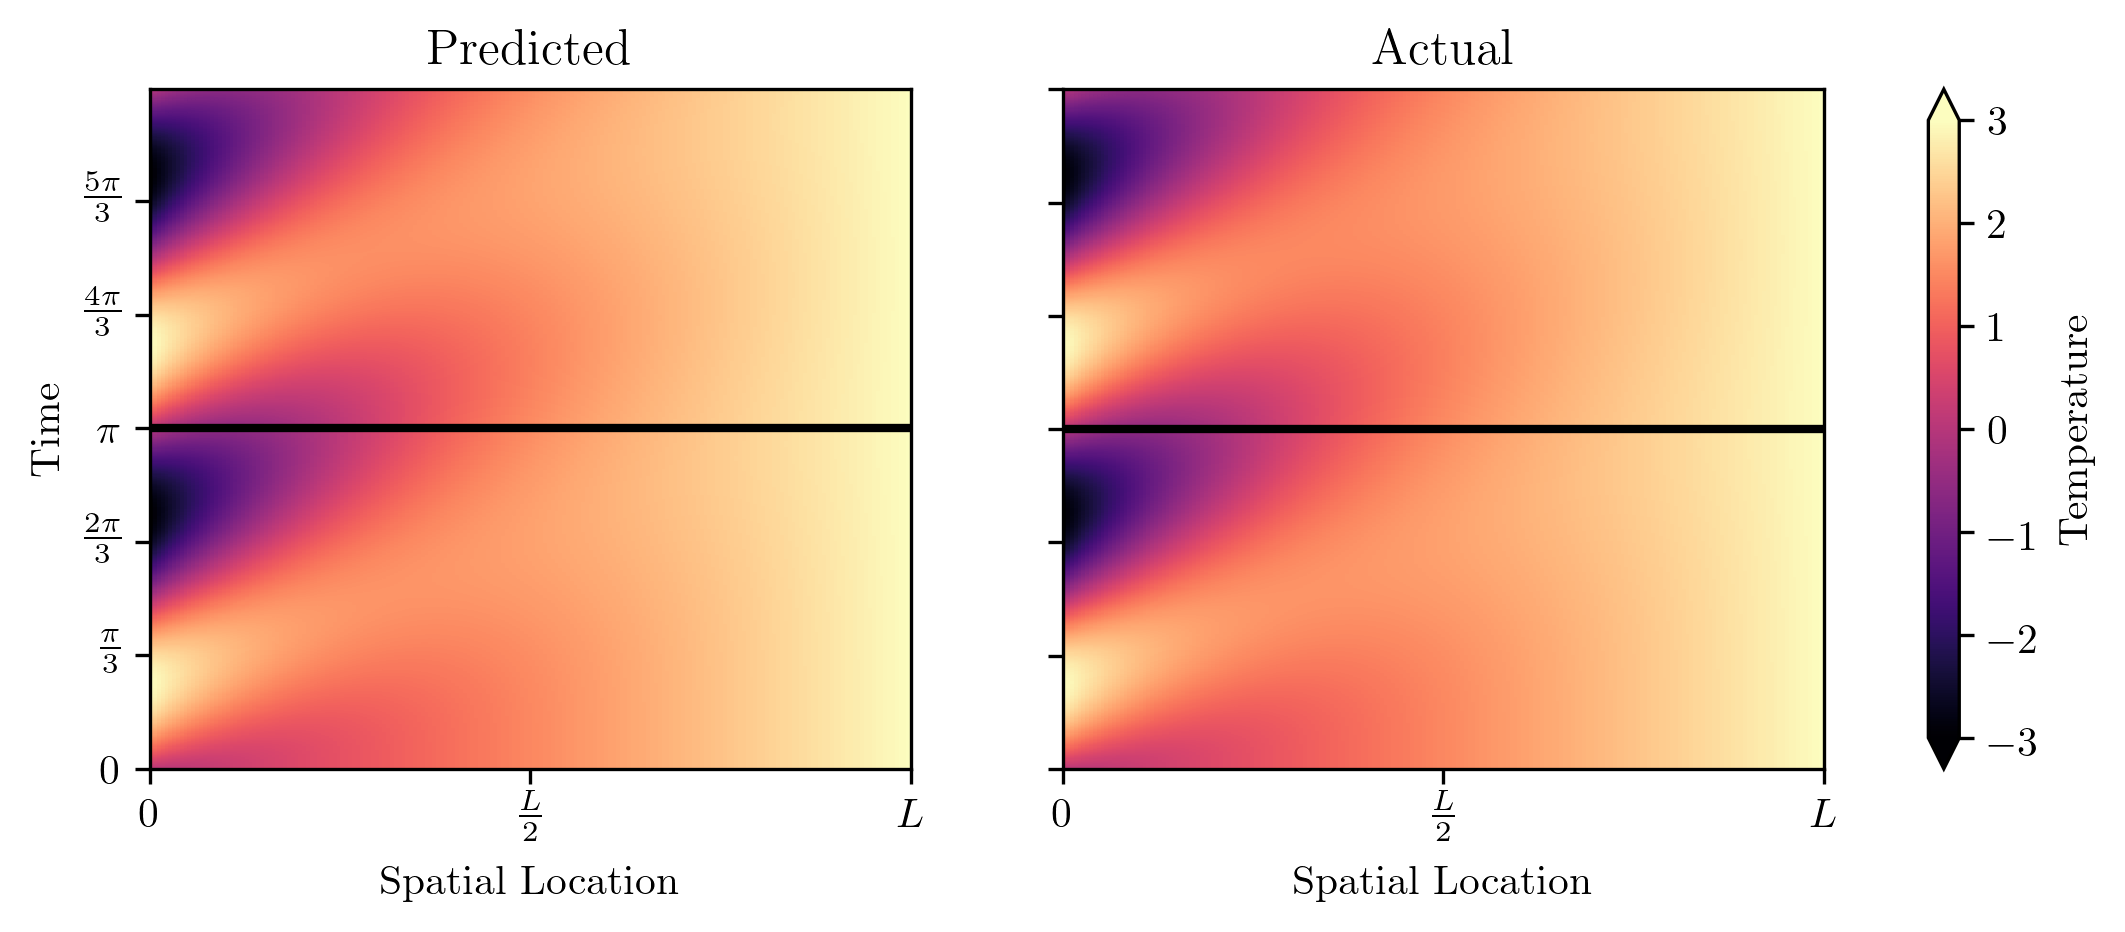

In [10]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9,3), sharey=True)

map1 = ax1.pcolormesh(XX, YY, x_ROM, cmap="magma", vmin=-3, vmax=3)
map2 = ax2.pcolormesh(XX, YY, original_data, cmap="magma", vmin=-3, vmax=3)
ax1.set_title("Predicted")
ax2.set_title("Actual")

for ax in [ax1, ax2]:
    ax.axhline(y=np.pi, c='k', lw=2)
    ax.axis([space.min(), space.max(), 0, 6.27])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel("Spatial Location")
ax1.set_ylabel("Time")
fig.colorbar(map1, ax=[ax1, ax2], label="Temperature", extend="both")
plt.show()

Visually, the predicted trajectory accurately captures the features of the actual trajectory.
For a closer look, we compute the absolute error of the projection.

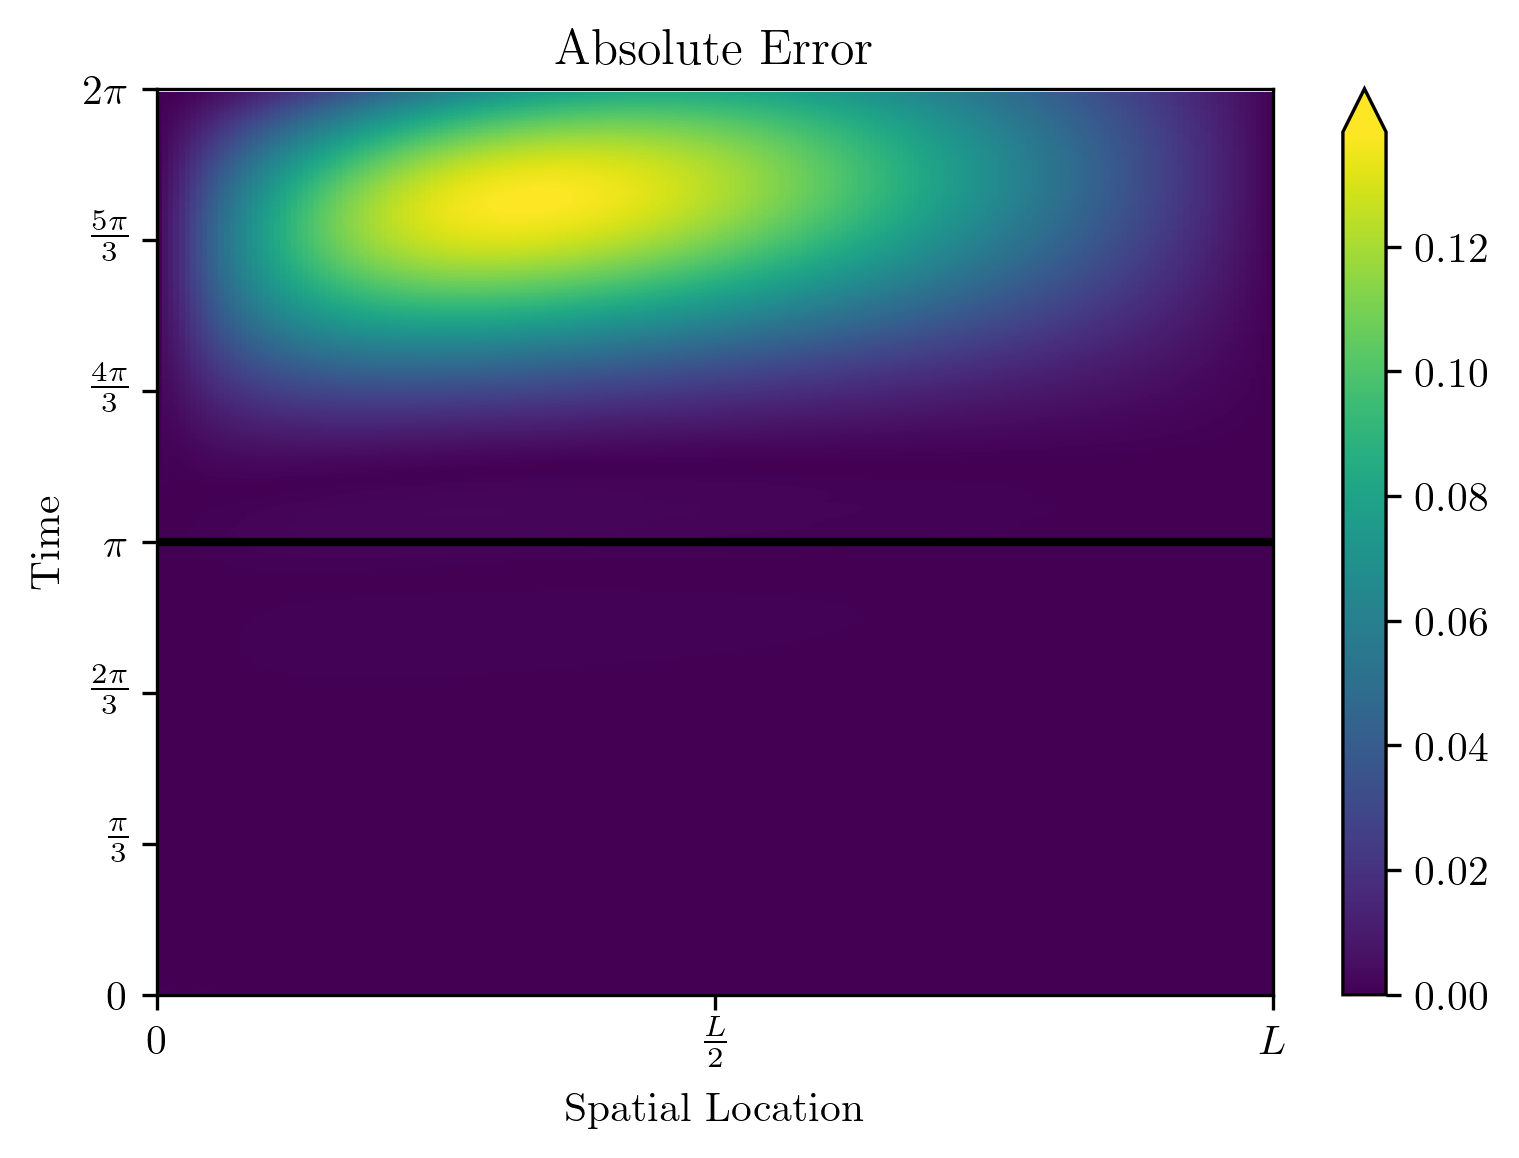

Maximum Absolute Error: 0.13840711772916658


In [11]:
absolute_error = np.abs(x_ROM - original_data)
maperr = plt.pcolormesh(XX, YY, absolute_error, vmin=0)
plt.axhline(y=np.pi, color='black', linewidth=2)

plt.axis([space.min(), space.max(), 0, 6.27])
plt.xlabel("Spatial Location")
plt.ylabel("Time")
plt.xticks(xticks, xticklabels)
plt.yticks(yticks, yticklabels)

plt.title("Absolute Error")

plt.colorbar(maperr, extend="max")
plt.show()

print("Maximum Absolute Error:", absolute_error.max())

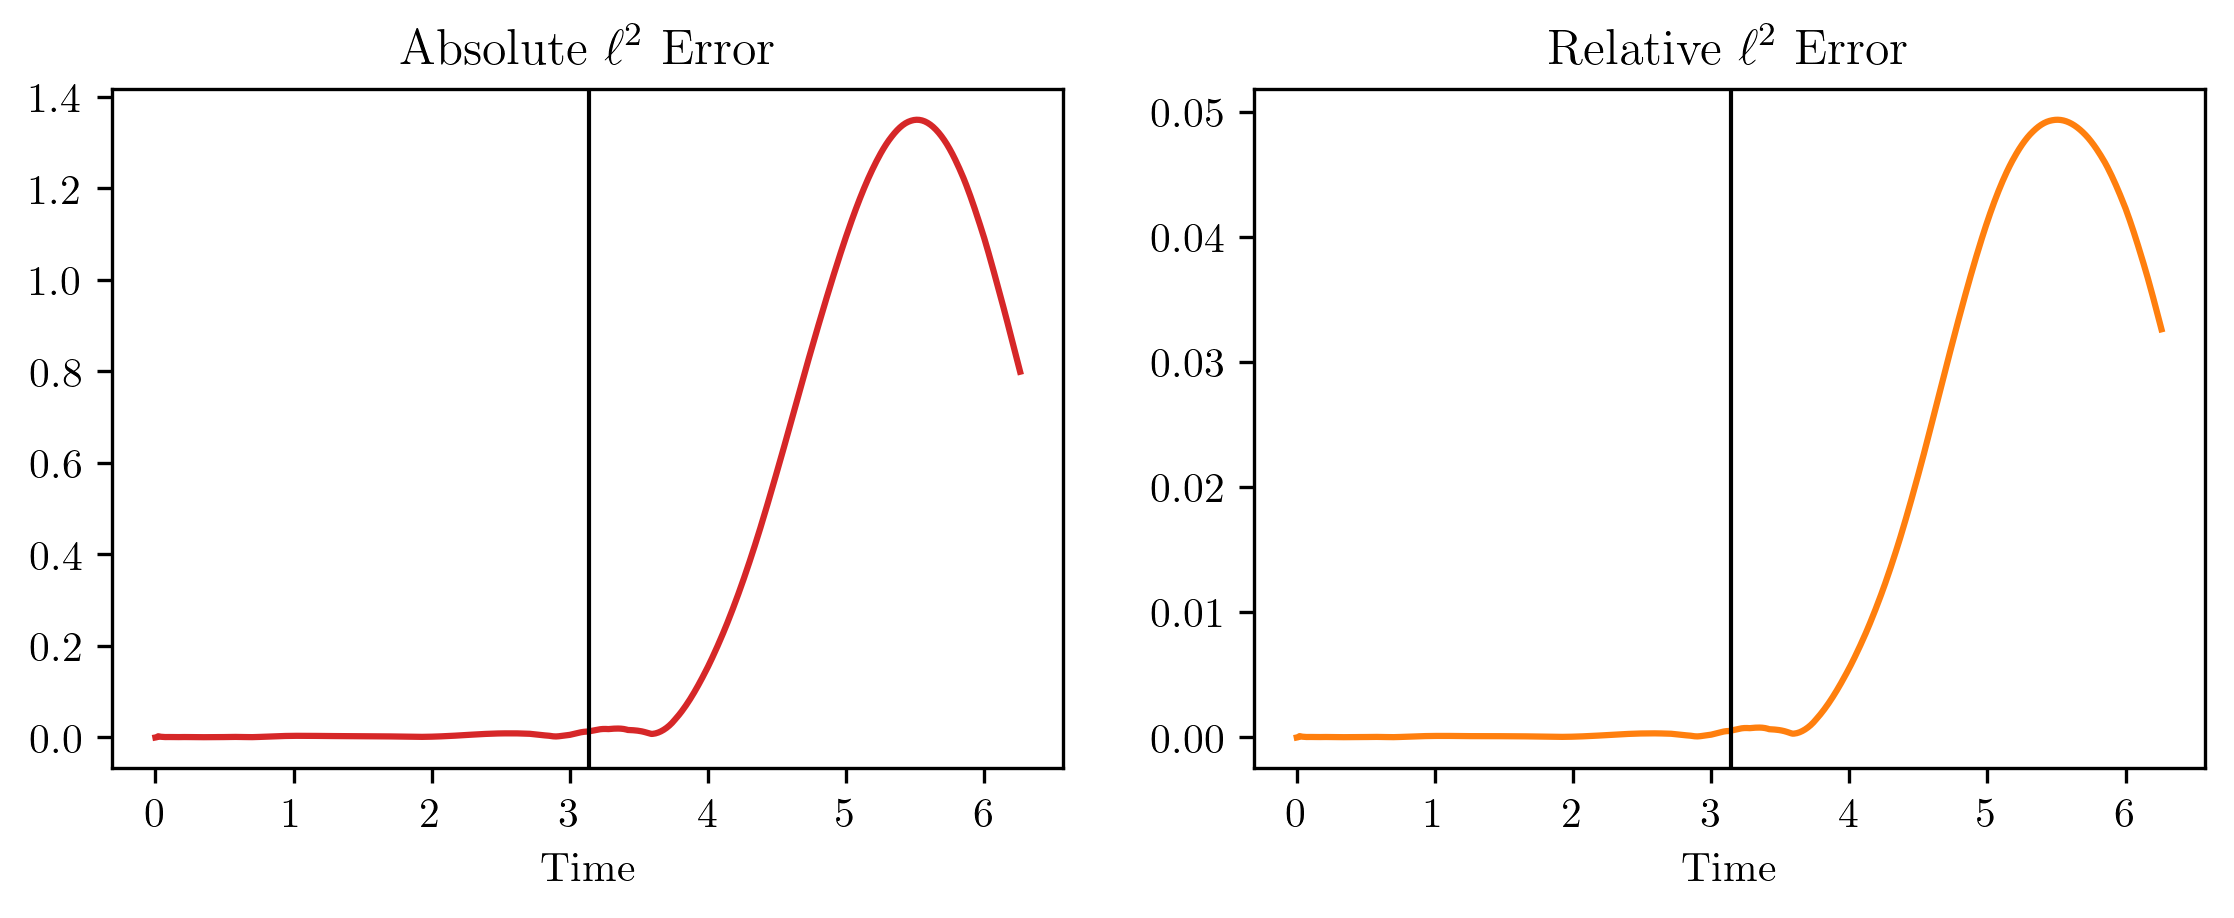

Relative L2 error: 2.234959%


In [12]:
l2_abserr, l2_relerr = roi.post.lp_error(original_data, x_ROM)
L2_abserr, L2_relerr = roi.post.Lp_error(original_data, x_ROM, time)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9,3), sharex=True)

ax1.plot(time, l2_abserr, 'C3-')
ax1.axvline(np.pi, color="black", linewidth=1)
ax1.set_xlabel(r"Time")
ax1.set_title(r"Absolute $\ell^2$ Error")

ax2.plot(time, l2_relerr, 'C1-')
ax2.axvline(np.pi, color="black", linewidth=1)
ax2.set_xlabel(r"Time")
ax2.set_title(r"Relative $\ell^2$ Error")

plt.show()
print(f"Relative L2 error: {L2_relerr:%}")

In the preceding figures, the black line represents the boundary between the training and testing regimes.
The error stays very controlled in the training regime, but gently fluctuates thereafter.